Import danych

In [90]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import db_dtypes
import statistics

ładowanie danych

In [91]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"] = "the-webbing-454111-s0-9a04cc92eadc.json"
client = bigquery.Client()

In [106]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    new_deceased AS `new_deceased`,
    new_confirmed AS `new_confirmed`,
    new_persons_vaccinated AS `new_persons_vaccinated`,
    average_temperature_celsius as `average_temperature_celsius`,
    new_tested as `new_tested`,
    MAX(population) AS `population`, 
    AVG(gdp_usd) AS `GDP`, 
    AVG(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`,
    date 
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE 
    aggregation_level = 0
GROUP BY 
    country_name, iso_3166_1_alpha_3, new_deceased, new_confirmed, new_persons_vaccinated, average_temperature_celsius, new_tested, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
disease_df.to_csv('results\\prepared_for_3_ex.csv', index=False)

merged_covid_df = pd.read_csv('results\\prepared_for_2_ex.csv')

c:\Users\Cente\Desktop\studia\6 semestr studiow\bigdata\BigData\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Wyznacz średnią kroczącą i odchylenie standardowe kroczące (np. 7-dniowe), aby zobaczyć, jak te zjawiska zmieniają się w czasie. Obliczenia wykonaj dla:

1.1. liczby nowych zachorowań,

1.2. liczby nowych śmierci,

1.3. liczby nowych szczepień,

1.4 2 innych różnych informacji, które uznasz za istotne.

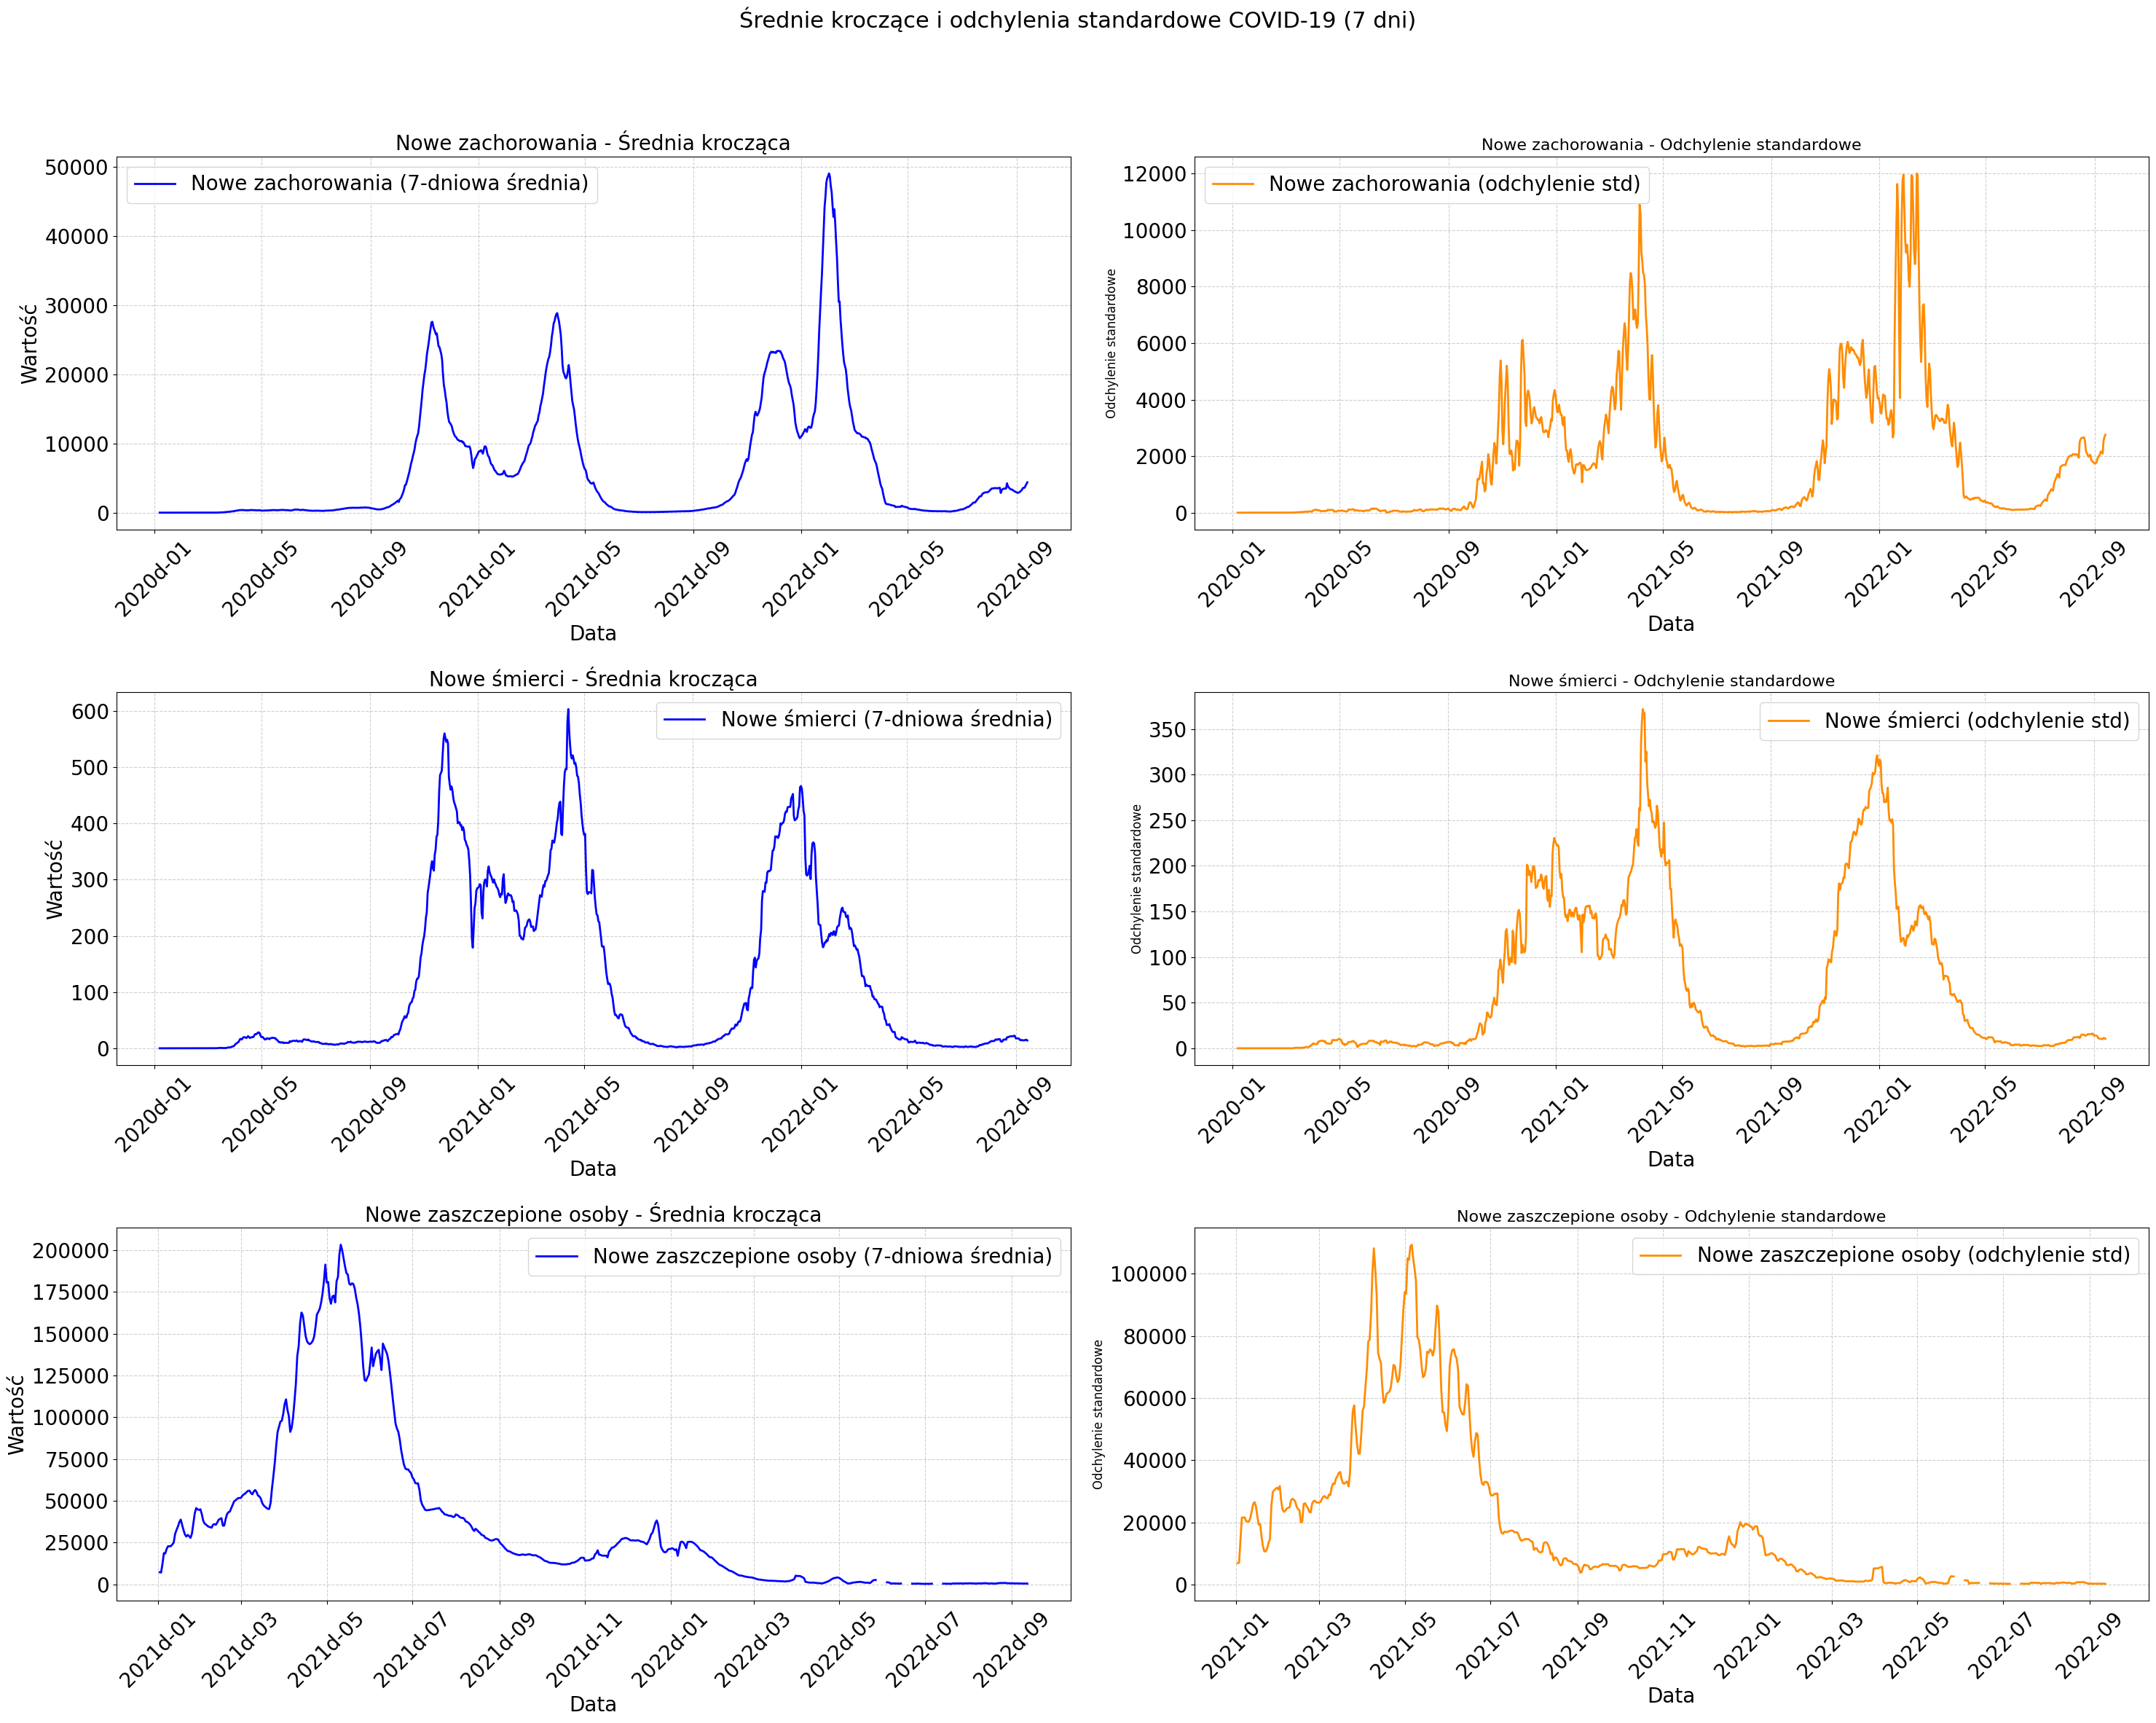

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Wczytaj dane
merged_covid_df = pd.read_csv('results\\prepared_for_3_ex.csv')
country = 'Poland'
merged_covid_df = merged_covid_df[merged_covid_df['country_name'] == country]

# Przetwarzanie daty i sortowanie
merged_covid_df['date'] = pd.to_datetime(merged_covid_df['date'])
merged_covid_df = merged_covid_df.sort_values(by='date')
merged_covid_df.set_index('date', inplace=True)

# Obliczenia rolling
rolling_window = 7
merged_covid_df['rolling_mean_new_confirmed'] = merged_covid_df['new_confirmed'].rolling(window=rolling_window).mean()
merged_covid_df['rolling_mean_new_deceased'] = merged_covid_df['new_deceased'].rolling(window=rolling_window).mean()
merged_covid_df['rolling_mean_new_persons_vaccinated'] = merged_covid_df['new_persons_vaccinated'].rolling(window=rolling_window).mean()
merged_covid_df['rolling_mean_average_temperature_celsius'] = merged_covid_df['average_temperature_celsius'].rolling(window=rolling_window).mean()
merged_covid_df['rolling_mean_new_tested'] = merged_covid_df['new_tested'].rolling(window=rolling_window).mean()


merged_covid_df['rolling_std_new_confirmed'] = merged_covid_df['new_confirmed'].rolling(window=rolling_window).std()
merged_covid_df['rolling_std_new_deceased'] = merged_covid_df['new_deceased'].rolling(window=rolling_window).std()
merged_covid_df['rolling_std_new_persons_vaccinated'] = merged_covid_df['new_persons_vaccinated'].rolling(window=rolling_window).std()
merged_covid_df['rolling_std_average_temperature_celsius'] = merged_covid_df['average_temperature_celsius'].rolling(window=rolling_window).std()
merged_covid_df['rolling_std_new_tested'] = merged_covid_df['new_tested'].rolling(window=rolling_window).std()


# Tworzenie wykresów
fig, axs = plt.subplots(3, 2, figsize=(30, 25))
fig.suptitle('Średnie kroczące i odchylenia standardowe COVID-19 (7 dni)', fontsize=22)

metrics = [
    ('Nowe zachorowania', 'rolling_mean_new_confirmed', 'rolling_std_new_confirmed'),
    ('Nowe śmierci', 'rolling_mean_new_deceased', 'rolling_std_new_deceased'),
    ('Nowe zaszczepione osoby', 'rolling_mean_new_persons_vaccinated', 'rolling_std_new_persons_vaccinated'),
]

for i, (label, mean, std) in enumerate(metrics):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    
    # Średnia krocząca
    ax1.plot(merged_covid_df.index, merged_covid_df[mean], label=f'{label} (7-dniowa średnia)', color='blue', linewidth=2)
    ax1.set_title(f'{label} - Średnia krocząca', fontsize=20)
    ax1.set_xlabel('Data', fontsize=20)
    ax1.set_ylabel('Wartość', fontsize=20)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.tick_params(axis='x', rotation=45)

    # Odchylenie standardowe
    ax2.plot(merged_covid_df.index, merged_covid_df[std], label=f'{label} (odchylenie std)', color='darkorange', linewidth=2)
    ax2.set_title(f'{label} - Odchylenie standardowe', fontsize=16)
    ax2.set_xlabel('Data', fontsize=20)
    ax2.set_ylabel('Odchylenie standardowe', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


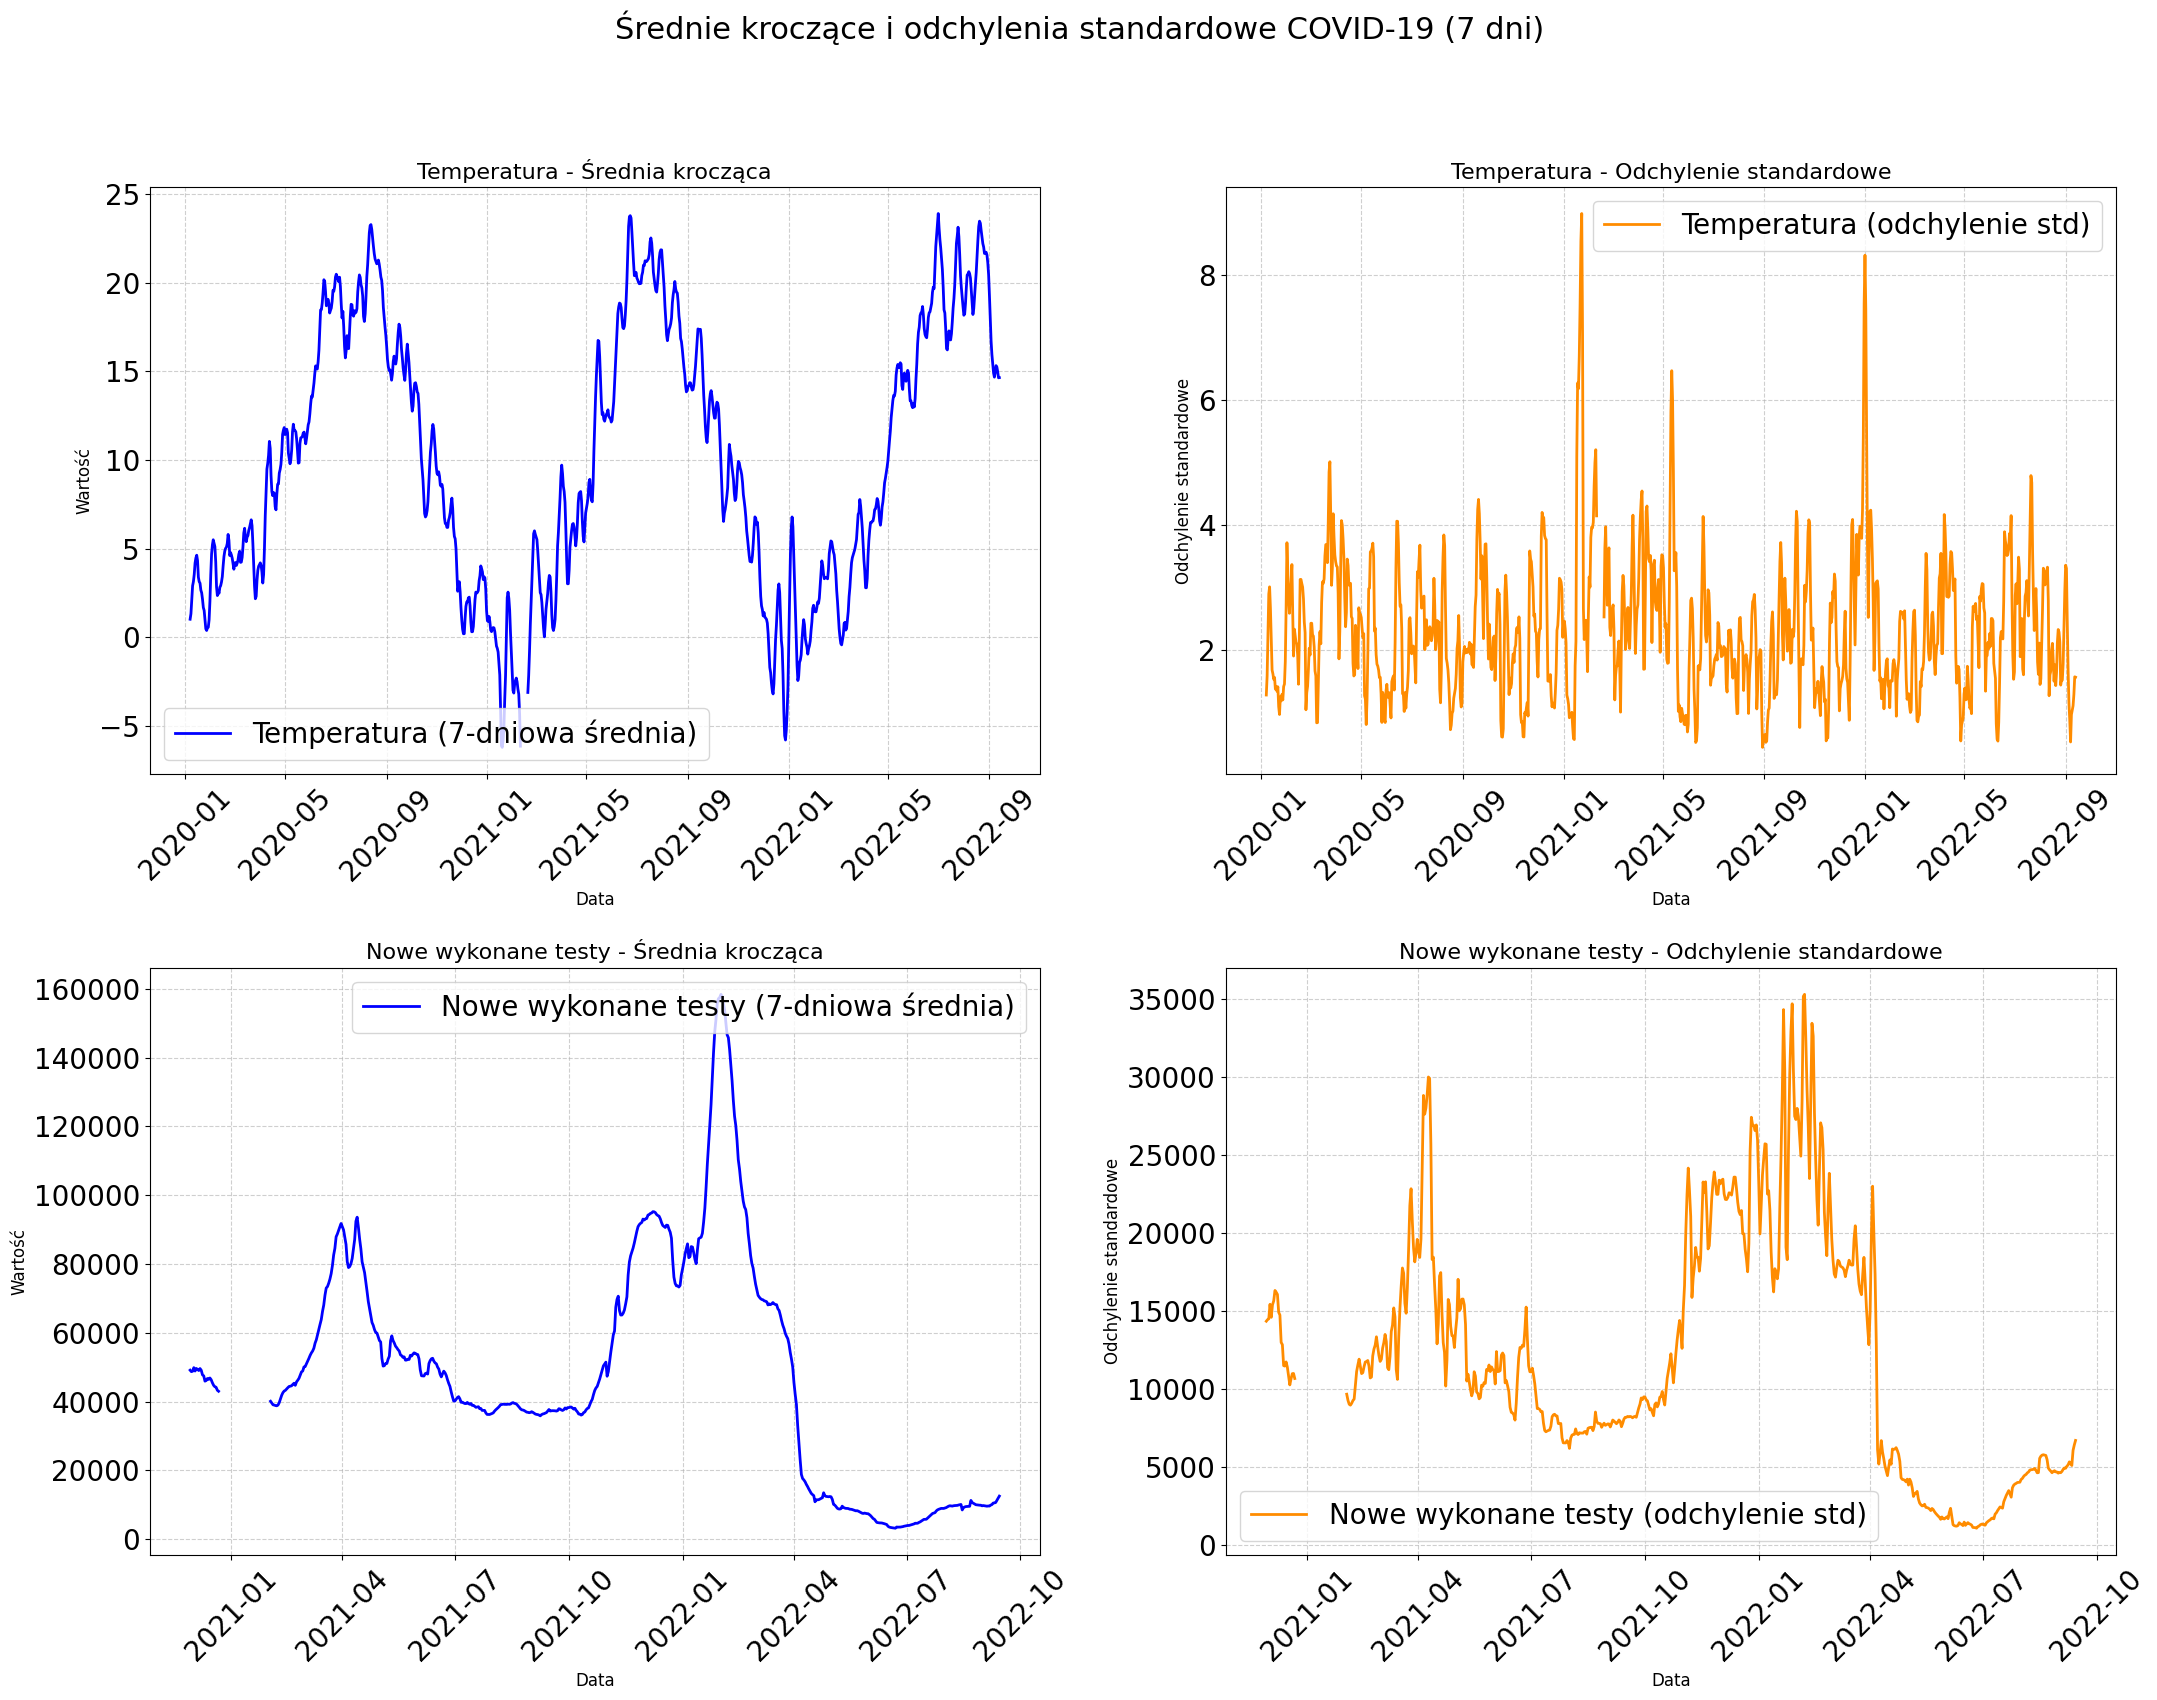

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(22, 18))
fig.suptitle('Średnie kroczące i odchylenia standardowe COVID-19 (7 dni)', fontsize=22)

metrics = [
    ('Temperatura', 'rolling_mean_average_temperature_celsius', 'rolling_std_average_temperature_celsius'),
    ('Nowe wykonane testy', 'rolling_mean_new_tested', 'rolling_std_new_tested'),
]

for i, (label, mean, std) in enumerate(metrics):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    
    # Średnia krocząca
    ax1.plot(merged_covid_df.index, merged_covid_df[mean], label=f'{label} (7-dniowa średnia)', color='blue', linewidth=2)
    ax1.set_title(f'{label} - Średnia krocząca', fontsize=16)
    ax1.set_xlabel('Data', fontsize=12)
    ax1.set_ylabel('Wartość', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.tick_params(axis='x', rotation=45)

    # Odchylenie standardowe
    ax2.plot(merged_covid_df.index, merged_covid_df[std], label=f'{label} (odchylenie std)', color='darkorange', linewidth=2)
    ax2.set_title(f'{label} - Odchylenie standardowe', fontsize=16)
    ax2.set_xlabel('Data', fontsize=12)
    ax2.set_ylabel('Odchylenie standardowe', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Część 2
Misja dodatkowa - Szeregi czasowe

In [ ]:
Wykorzystaj do analizy trendów analizę szeregów czasowych (metoda średniej ruchomej czy inne modele autoregresyjne), 
która umożliwi zbadanie 5 przypadków rozważanych w części 1 poziomu 3. Przygotuj wykresy w celu porównania otrzymanych wyników. 
Pamiętaj o ich czytelności (typ wykresu, tytuł wykresu, podpisy osi, odpowiednie zakresy osi, itp.). Przeanalizuj otrzymane wizualizacje.